# Model Evaluations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

import model_metrics_helper

## 0. Load prediction results from model

In [2]:
result = pd.read_csv("../real_time_sepsis_development/xgb_model_0420/prediction_results_0420.csv")

# MODIFYING to replace csn/pat_id with random int

csns = list(result.csn.unique())
pat_id = list(result.pat_id.unique())
rename_dic = {csn:i  for i, csn in enumerate(csns)}
result["csn"] = result["csn"].replace(rename_dic)
result["pat_id"] = result["csn"]

########################################

result

,csn,pat_id,LOS,rel_time,SepsisLabel,PredictedProbability,PredictedSepsisLabel
0,0,0,0,1.0,0,0.039584,0
1,0,0,3,4.0,0,0.315882,0
2,1,1,0,1.0,0,0.026124,0
3,1,1,3,4.0,0,0.017476,0
4,1,1,6,7.0,0,0.023783,0
...,...,...,...,...,...,...,...
32877,4605,4605,36,37.0,1,0.623994,1
32878,4605,4605,39,40.0,1,0.642301,1
32879,4605,4605,42,43.0,1,0.638215,1
32880,4605,4605,45,46.0,1,0.630411,1


## 1. Generate Benchmarks

In [3]:
# load dataframe with all features; post pre-processing
data = pd.read_csv("../real_time_sepsis_development/real_time_data/2021_6hr_preprocessed_48.csv")
# MODIFYING to replace csn/pat_id with random int
data["csn"] = data["csn"].replace(rename_dic)
data["pat_id"] = data["csn"]

In [4]:
# SIRS score
SIRS = model_metrics_helper.SIRS(data)
# MEWS score
MEWS = model_metrics_helper.MEWS(data)

In [5]:
# merge with prediction results
result = result.merge(SIRS, on = ["csn", "pat_id", "rel_time"], how = "left")
result = result.merge(MEWS, on = ["csn", "pat_id", "rel_time"], how = "left")

In [6]:
result

,csn,pat_id,LOS,rel_time,SepsisLabel,PredictedProbability,PredictedSepsisLabel,SIRS,MEWS
0,0,0,0,1.0,0,0.039584,0,1,2
1,0,0,3,4.0,0,0.315882,0,1,3
2,1,1,0,1.0,0,0.026124,0,0,2
3,1,1,3,4.0,0,0.017476,0,0,2
4,1,1,6,7.0,0,0.023783,0,0,2
...,...,...,...,...,...,...,...,...,...
33141,4605,4605,36,37.0,1,0.623994,1,1,1
33142,4605,4605,39,40.0,1,0.642301,1,1,1
33143,4605,4605,42,43.0,1,0.638215,1,1,1
33144,4605,4605,45,46.0,1,0.630411,1,1,1


In [7]:
# Common benchmark
# SIRS: when SIRS >= 2
# MEWS: when MEWS >= 5

result["SIRS"] = result["SIRS"] >= 2
result["MEWS"] = result["MEWS"] >= 5

## 2. ROC and PR curve model

MEWS: ROC AUC=0.528
48-hour model: ROC AUC=0.880


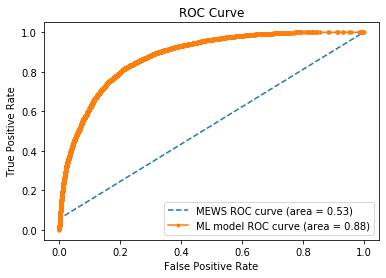

48-hour model: f1=0.619 auc=0.652


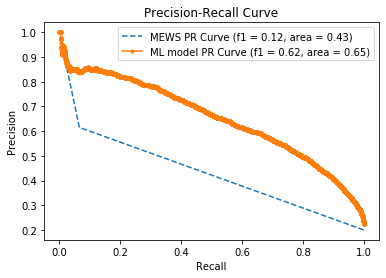

In [9]:
model_metrics_helper.roc_pr_curve(result, "MEWS")

SIRS: ROC AUC=0.653
48-hour model: ROC AUC=0.880


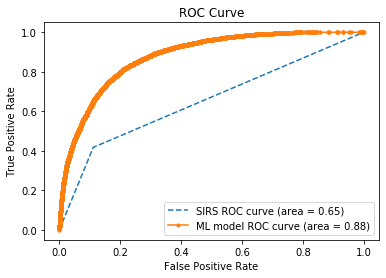

48-hour model: f1=0.619 auc=0.652


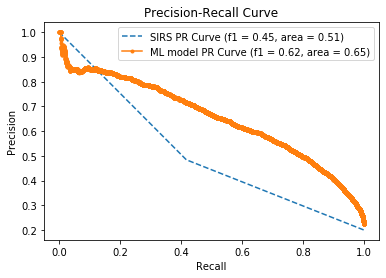

In [10]:
model_metrics_helper.roc_pr_curve(result, "SIRS")

### 3.0 metric null
- takes all rows as testing entries, no modification to the standard way of defining TP/TN/FP/FN. 
- input: dataframe of result and label (aka PredictionSepsisLabel (by ML), MEWS, or SIRS)
- output: confusion matrix, classification report, and result per patient in csv file

Confusion matrix : 
 [[  438  6209]
 [  274 26225]]
Outcome values :  
TP:  438 
FN:  6209 
FP:  274 
TN:  26225
Classification report : 
               precision    recall  f1-score   support

           1     0.6152    0.0659    0.1190      6647
           0     0.8086    0.9897    0.8900     26499

    accuracy                         0.8044     33146
   macro avg     0.7119    0.5278    0.5045     33146
weighted avg     0.7698    0.8044    0.7354     33146


 average patient level metrics 
 average PPV: 0.9722 
 average NPV: 0.9166 
 average Specificity: 0.9873 
 average Sensitivity: 0.9157 



,csn,SepsisLabel,MEWS,fp,tn,tp,fn,Possible_Alarms,Accuracy,PPV,NPV,Sensitivity,Specificity
0,0,0,0,0,2,0,0,2,1.0,NaN,1.0,NaN,1.0
1,1,0,0,0,4,0,0,4,1.0,NaN,1.0,NaN,1.0
2,2,0,0,0,17,0,0,17,1.0,NaN,1.0,NaN,1.0
3,3,0,0,0,1,0,0,1,1.0,NaN,1.0,NaN,1.0
4,4,0,0,0,2,0,0,2,1.0,NaN,1.0,NaN,1.0


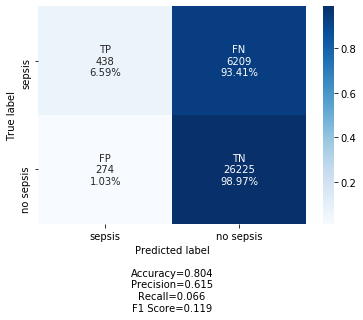

In [12]:
cf_matrix, _, patient_alarms = model_metrics_helper.metric_null(result, label = "MEWS")
patient_alarms.head()

Confusion matrix : 
 [[ 5143  1504]
 [ 4836 21663]]
Outcome values :  
TP:  5143 
FN:  1504 
FP:  4836 
TN:  21663
Classification report : 
               precision    recall  f1-score   support

           1     0.5154    0.7737    0.6187      6647
           0     0.9351    0.8175    0.8723     26499

    accuracy                         0.8087     33146
   macro avg     0.7252    0.7956    0.7455     33146
weighted avg     0.8509    0.8087    0.8215     33146


 average patient level metrics 
 average PPV: 0.8642 
 average NPV: 0.9485 
 average Specificity: 0.9203 
 average Sensitivity: 0.9795 



,csn,SepsisLabel,PredictedSepsisLabel,fp,tn,tp,fn,Possible_Alarms,Accuracy,PPV,NPV,Sensitivity,Specificity
0,0,0,0,0,2,0,0,2,1.000000,NaN,1.0,NaN,1.000000
1,1,0,0,0,4,0,0,4,1.000000,NaN,1.0,NaN,1.000000
2,2,0,14,14,3,0,0,17,0.176471,0.0,1.0,NaN,0.176471
3,3,0,0,0,1,0,0,1,1.000000,NaN,1.0,NaN,1.000000
4,4,0,0,0,2,0,0,2,1.000000,NaN,1.0,NaN,1.000000


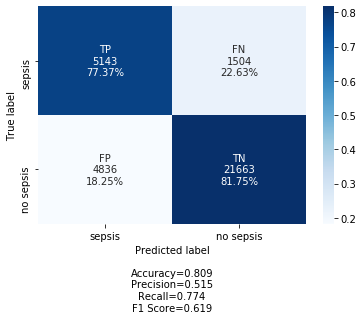

In [13]:
cf_matrix, _, patient_alarms = model_metrics_helper.metric_null(result, label = "PredictedSepsisLabel")
patient_alarms.head()

# 3.1 metric 1
- takes all rows as testing entries
- if guessed max 6 hours earlier, count as true positive

Confusion matrix : 
 [[  450  6209]
 [  262 26225]]
Outcome values :  
TP:  450 
FN:  6209 
FP:  262 
TN:  26225
Classification report : 
               precision    recall  f1-score   support

           1     0.6320    0.0676    0.1221      6659
           0     0.8086    0.9901    0.8902     26487

    accuracy                         0.8048     33146
   macro avg     0.7203    0.5288    0.5061     33146
weighted avg     0.7731    0.8048    0.7359     33146


 average patient level metrics 
 average PPV: 0.974 
 average NPV: 0.9166 
 average Specificity: 0.9892 
 average Sensitivity: 0.9158 

changes from null: 
 [[ 12   0]
 [-12   0]]


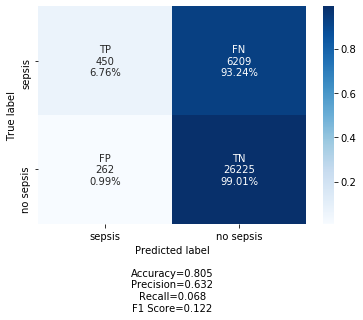

In [14]:
_, _, alarms_result1 = model_metrics_helper.metric_one(result, label = "MEWS")

In [16]:
alarms_result1.head()

,csn,SepsisLabel,MEWS,fp,tn,tp,fn,Possible_Alarms,Accuracy,PPV,NPV,Sensitivity,Specificity
0,0,0,0,0,2,0,0,2,1.0,NaN,1.0,NaN,1.0
1,1,0,0,0,4,0,0,4,1.0,NaN,1.0,NaN,1.0
2,2,0,0,0,17,0,0,17,1.0,NaN,1.0,NaN,1.0
3,3,0,0,0,1,0,0,1,1.0,NaN,1.0,NaN,1.0
4,4,0,0,0,2,0,0,2,1.0,NaN,1.0,NaN,1.0


## 3.2 Metric 2
- snooze option is available. 
- replicate case when clinician would snooze the rest of the IF prediction alarms correctly TWICE!


Confusion matrix : 
 [[  759  1037]
 [ 4737 21661]]
Outcome values :  
TP:  759 
FN:  1037 
FP:  4737 
TN:  21661
Classification report : 
               precision    recall  f1-score   support

           1     0.1381    0.4226    0.2082      1796
           0     0.9543    0.8206    0.8824     26398

    accuracy                         0.7952     28194
   macro avg     0.5462    0.6216    0.5453     28194
weighted avg     0.9023    0.7952    0.8394     28194


 average patient level metrics 
 average PPV: 0.8638 
 average NPV: 0.9561 
 average Specificity: 0.9261 
 average Sensitivity: 0.9732 



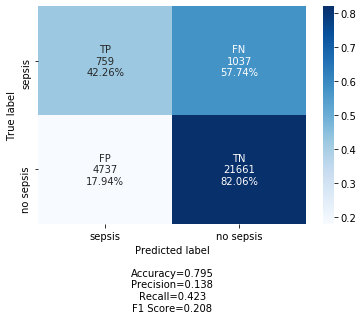

In [17]:
_, _, alarms_result2 = model_metrics_helper.metric_two(result, label = "PredictedSepsisLabel")